In [5]:
import pandas as pd
import numpy as np
import sys
import os
import time
import random
import copy
import math
import scanpy as sc
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl

import seaborn as sns
import autoreload
import scipy
params = {
    'font.size': 12,
    'axes.titlesize': 12,
    'axes.labelsize': 12,
    'legend.fontsize': 12,
    'xtick.labelsize': 8,
    'ytick.labelsize': 10,
    'font.family': "Helvetica",
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'figure.dpi': 300
   }

### Analyzing Coronavirus bulk RNA seq Samples

#### Possible analyses: 

Is C gene usage different between the groups? 
J gene usage? 
v gene usage? 

Are more assemblies gathered from a group than another, when normalized for how many samples? 

Are there differences in the CDR3s of healthy vs non-healthy? 
 




In [6]:
df_cdr = pd.read_csv('../data/cdr3_merged.tsv', sep = '\t', index_col=0)

In [7]:
df_cdr.groupby('sample').V_gene.value_counts()

sample               V_gene                  
TRUST_20H-078VI0209  IGKV1-5*03                   1
                     IGKV2-28*01,IGKV2D-28*01     1
                     TRGV3*01                     1
TRUST_20H-112VI0067  TRBV13*01,TRBV2*01          21
                     *                            2
                                                 ..
TRUST_20S-127VI0698  TRBV9*01                     1
                     TRGV4*01                     1
                     TRGV5*01,TRGV3*01            1
                     TRGV5P*01                    1
                     TRGV8*01                     1
Name: V_gene, Length: 5527, dtype: int64

In [203]:
metadata1 = pd.read_csv('../data/metadata3.csv', index_col = 0)


In [204]:
metadata1['SampleID'] = metadata['seqLabel']

In [206]:

df_report = pd.read_csv('../data/reports_merged.tsv', sep = '\t', index_col = 0)

metadata = pd.read_csv('../data/covidPatientMetaData2 - Clean.tsv', sep = '\t')
metadata.pop('Unnamed: 2')
metadata = pd.merge(metadata, metadata1, how ='left', left_on='SampleID', right_on='SampleID')
# Split TRUST from sample name to merge properly
df_report['sample'] = df_report['sample'].str.split('_', expand = True)[1]

# merge metadata and report
mdf = pd.merge(df_report, metadata,how = 'left', left_on = 'sample', right_on = 'SampleID')

### IgH Counts

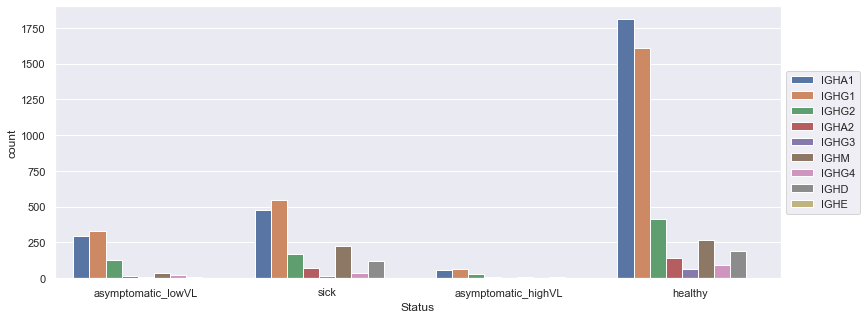

In [208]:
data = mdf[mdf['C'] != '*']
data = mdf[mdf['C'].str.contains('IGH')]
# Count plot 
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(13, 5))
sns.countplot(x = 'Status', data = data, hue='C')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [212]:
# Try filtering out 1 read assemblies
#data = mdf[mdf['#count'] > 2]

In [213]:
data = mdf[mdf['C'] != '*']
data = mdf[mdf['C'].str.contains('IGH')]

_data = data.groupby('Status').C.value_counts(normalize = True).unstack()

_data = _data.reset_index().melt(id_vars = 'Status')

### Bar plot Normalized

Text(0, 0.5, 'Isotype Proportion')

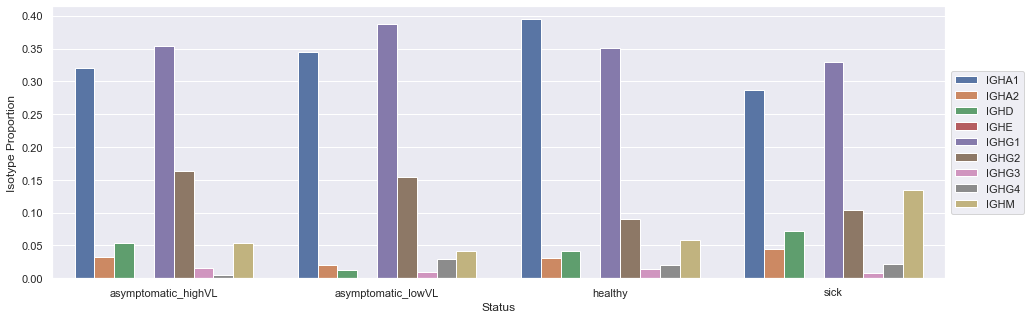

In [214]:
data = _data
# Barplot plot 
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(16, 5))
sns.barplot(x = 'Status', data = data, hue='C', y = 'value')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel("Isotype Proportion")

### Barplot Drop IGHE and IGG4 for visualization purposes

Text(0, 0.5, 'Isotype Proportion')

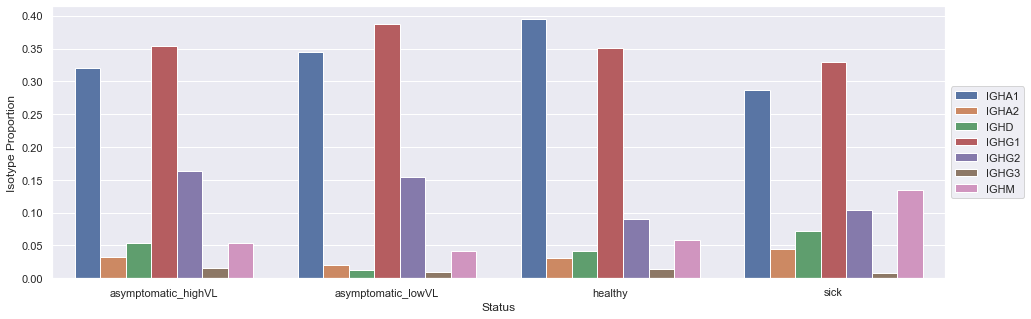

In [215]:
data = _data
data = data[~data.C.str.contains('IGHE|IGHG4')]

sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(16, 5))
sns.barplot(x = 'Status', data = data, hue='C', y = 'value')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel("Isotype Proportion")

## Chi Square Test

In [216]:
# only IgH Genes
data = mdf[mdf['C'].str.contains('IGH')]
# exclude IGHE because it would violate Chit squared assumptions (0 counts)
data = data[~data['C'].str.contains('IGHE|IGHG4')]
#_data = data.groupby('Group').C.value_counts(normalize = True).unstack()
# Don't normalize
_data = data.groupby('Status').C.value_counts(normalize = False).unstack()

_data = _data.reset_index().melt(id_vars = 'Status')
# Fill na's (non-detected IGHEs)
_data.fillna(0, inplace = True)

In [217]:
# codingdisciple.com/chi-squared-python.html
contingency_table = pd.crosstab(data['Status'], data['C'], margins = True)

In [218]:
contingency_table

C,IGHA1,IGHA2,IGHD,IGHG1,IGHG2,IGHG3,IGHM,All
Status,,,,,,,,
asymptomatic_highVL,59,6,10,65,30,3,10,183
asymptomatic_lowVL,292,17,11,328,130,8,35,821
healthy,1810,141,194,1607,412,62,268,4494
sick,477,74,119,548,172,14,224,1628
All,2638,238,334,2548,744,87,537,7126


Contingency table looks right

In [219]:
# Asymptomatic Negative (healthy, OccHealth)
asy_hVL = contingency_table.iloc[0][:-1]
asy_lVL = contingency_table.iloc[1][:-1]
healthy = contingency_table.iloc[2][:-1]
sick = contingency_table.iloc[3][:-1]
f_obs = np.array([healthy.values, asy_hVL.values]) #contingency_table.iloc[2][:9].values)

from scipy import stats

stats.chi2_contingency(f_obs)

(13.25954775032503,
 0.039094544285793224,
 6,
 array([[1795.87042976,  141.24823605,  196.01796023, 1606.57857601,
          424.7055805 ,   62.45670301,  267.12251443],
        [  73.12957024,    5.75176395,    7.98203977,   65.42142399,
           17.2944195 ,    2.54329699,   10.87748557]]))

In [220]:
test_list = [asy_hVL, asy_lVL, healthy, sick]

In [221]:
# Generate all possible combinations of tests and then run Chi-squared (may need multiple correction test?)
import itertools

combos = itertools.combinations(test_list, 2)

for comparison in combos: 
    one, two = comparison
    print(one.name, two.name)
    f_obs = np.array([one.values, two.values])
    print(stats.chi2_contingency(f_obs))

asymptomatic_highVL asymptomatic_lowVL
(15.464548377721048, 0.016935544594162143, 6, array([[ 63.97709163,   4.19223108,   3.82768924,  71.63247012,
         29.16334661,   2.00498008,   8.20219124],
       [287.02290837,  18.80776892,  17.17231076, 321.36752988,
        130.83665339,   8.99501992,  36.79780876]]))
asymptomatic_highVL healthy
(13.259547750325032, 0.03909454428579316, 6, array([[  73.12957024,    5.75176395,    7.98203977,   65.42142399,
          17.2944195 ,    2.54329699,   10.87748557],
       [1795.87042976,  141.24823605,  196.01796023, 1606.57857601,
         424.7055805 ,   62.45670301,  267.12251443]]))
asymptomatic_highVL sick
(16.866733265828575, 0.009785701656759656, 6, array([[ 54.16234125,   8.08393153,  13.03533959,  61.94312535,
         20.41192711,   1.71783545,  23.64549972],
       [481.83765875,  71.91606847, 115.96466041, 551.05687465,
        181.58807289,  15.28216455, 210.35450028]]))
asymptomatic_lowVL healthy
(60.49380022594184, 3.572454012869

### Read counts distribution for each assembly

In [222]:
mdf['log_readcounts'] = np.log10(mdf['#count'])

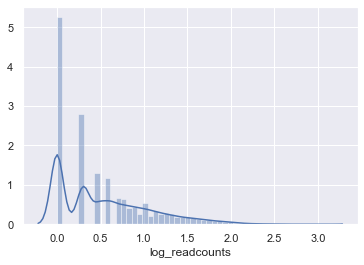

In [223]:
sns.distplot(mdf['log_readcounts'])

In [224]:
# T cells

Text(0, 0.5, 'Isotype Proportion')

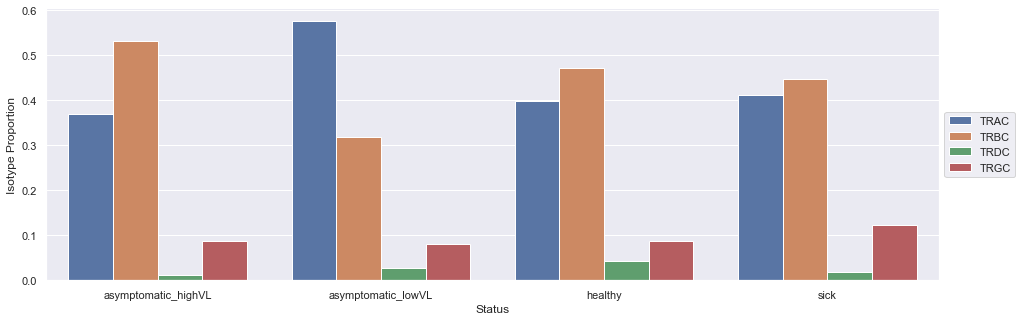

In [225]:
# Exclude IgH Genes and no Assignment
data = mdf[~mdf['C'].str.contains('IGH|IGL|IGK|\*')]

_data = data.groupby('Status').C.value_counts(normalize = True).unstack()

_data = _data.reset_index().melt(id_vars = 'Status')
# Fill na's (non-detected IGHEs)
_data.fillna(0, inplace = True)

data = _data
#data = data[~data.C.str.contains('*')]

sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(16, 5))
sns.barplot(x = 'Status', data = data, hue='C', y = 'value')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel("Isotype Proportion")

Asymptomatic Healthy have more of the Alpha Chain and Beta Chain, Everything else looks quite similar

Text(0, 0.5, 'Isotype Proportion')

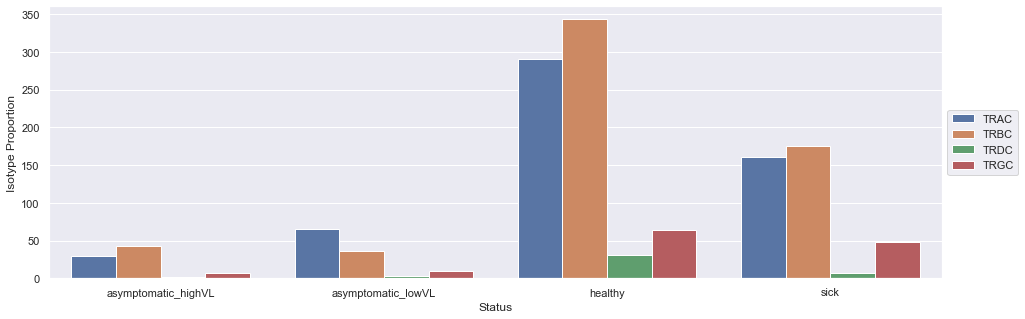

In [226]:
# Exclude IgH Genes and no Assignment
data = mdf[~mdf['C'].str.contains('IGH|IGL|IGK|\*')]

_data = data.groupby('Status').C.value_counts(normalize = False).unstack()

_data = _data.reset_index().melt(id_vars = 'Status')
# Fill na's (non-detected IGHEs)
_data.fillna(0, inplace = True)

data = _data
#data = data[~data.C.str.contains('*')]

sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(16, 5))
sns.barplot(x = 'Status', data = data, hue='C', y = 'value')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel("Isotype Proportion")

In [227]:
# Chi Squared Test
# Exclude IgH Genes and no Assignment
data = mdf[~mdf['C'].str.contains('IGH|IGL|IGK|\*')]

_data = data.groupby('Status').C.value_counts(normalize = False).unstack()

In [228]:
contingency_table = pd.crosstab(data['Status'], data['C'], margins = True)

In [229]:
contingency_table

C,TRAC,TRBC,TRDC,TRGC,All
Status,,,,,
asymptomatic_highVL,30,43,1,7,81
asymptomatic_lowVL,65,36,3,9,113
healthy,290,343,31,64,728
sick,161,175,7,48,391
All,546,597,42,128,1313


In [230]:
f_obs = np.array([contingency_table.iloc[0][:-1].values, contingency_table.iloc[1][:-1].values, contingency_table.iloc[2][:-1].values])


# asymptomatic vs symptomatic
f_obs = f_obs[1:]
print
from scipy import stats

stats.chi2_contingency(f_obs)

(13.000691266577943,
 0.004635110772951864,
 3,
 array([[ 47.69916766,  50.92390012,   4.56837099,   9.80856124],
        [307.30083234, 328.07609988,  29.43162901,  63.19143876]]))

In [231]:
f_obs = np.array([contingency_table.iloc[0][:-1].values, contingency_table.iloc[1][:-1].values, contingency_table.iloc[2][:-1].values])


In [232]:
# asymptomatic vs symptomatic
f_obs = f_obs[:-1]

from scipy import stats

stats.chi2_contingency(f_obs)

(9.751971044759628,
 0.020796514768244578,
 3,
 array([[39.66494845, 32.98453608,  1.67010309,  6.68041237],
        [55.33505155, 46.01546392,  2.32989691,  9.31958763]]))

## IgL Gene Analysis for good measure

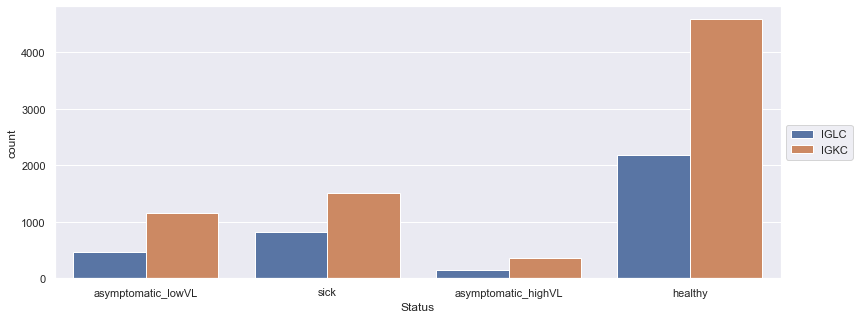

In [233]:
data = mdf[mdf['C'] != '*']
data = mdf[mdf['C'].str.contains('IGL|IGK')]
# Count plot 
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(13, 5))
sns.countplot(x = 'Status', data = data, hue='C')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Text(0, 0.5, 'Isotype Proportion')

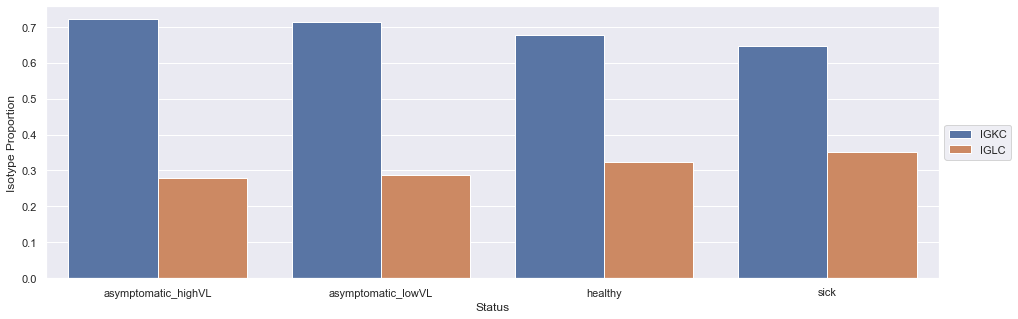

In [234]:
data = mdf[mdf['C'] != '*']
data = mdf[mdf['C'].str.contains('IGL|IGK')]

_data = data.groupby('Status').C.value_counts(normalize = True).unstack()

_data = _data.reset_index().melt(id_vars = 'Status')

data = _data
# Barplot plot 
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(16, 5))
sns.barplot(x = 'Status', data = data, hue='C', y = 'value')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel("Isotype Proportion")

## Variable IgH Gene Analysis

In [235]:
data = mdf[mdf['V'] != '*']
data = mdf[mdf['V'].str.contains('IGH|IGK|IGL')]
_data = data.groupby('Status').V.value_counts(normalize = True).unstack()

/Users/mswift/miniconda3/envs/singlecell/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


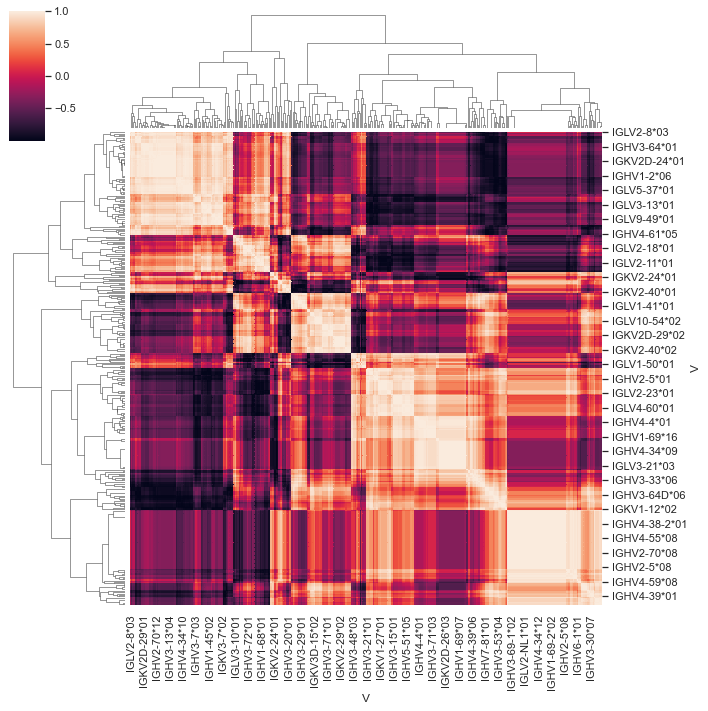

In [236]:
sns.clustermap(_data.fillna(0).corr())

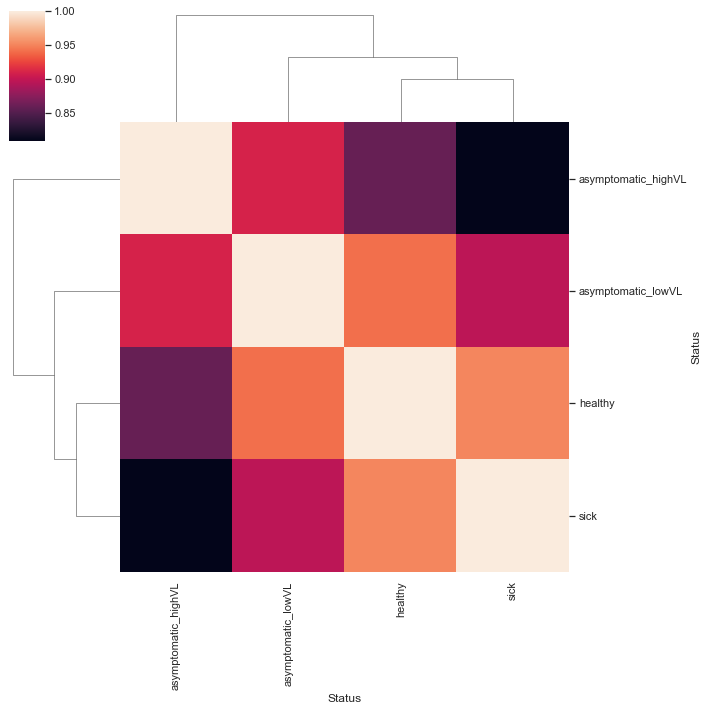

In [237]:
sns.clustermap(_data.fillna(0).T.corr())

In [238]:
_data = _data.fillna(0)

In [239]:
# Drop genes detected at levels of less than threshold
threshold = 0.001
selector = _data[_data > threshold].fillna(0).sum(axis = 0) > 0

In [240]:
selector = selector[selector == True].index

In [241]:
# Filtered Gene proportions
_data = _data[list(selector)]

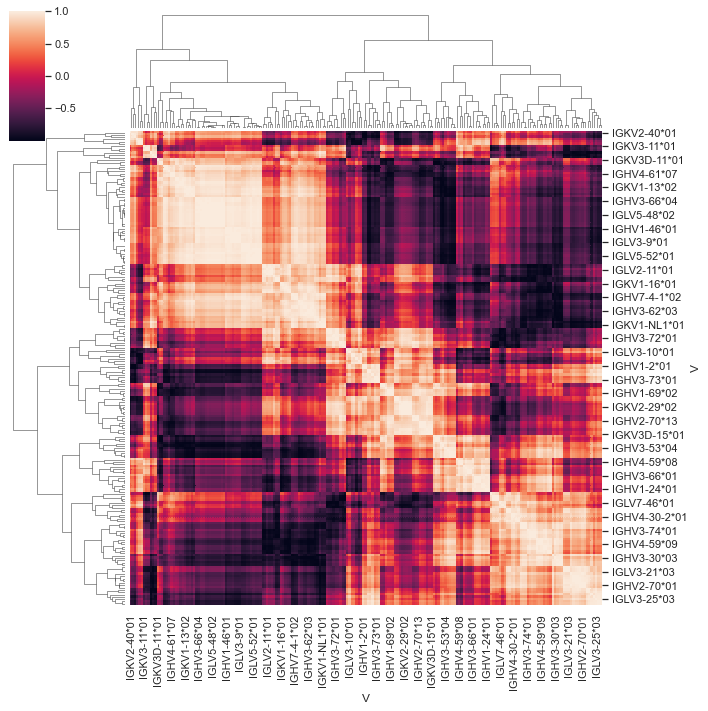

In [242]:
sns.clustermap(_data.corr())

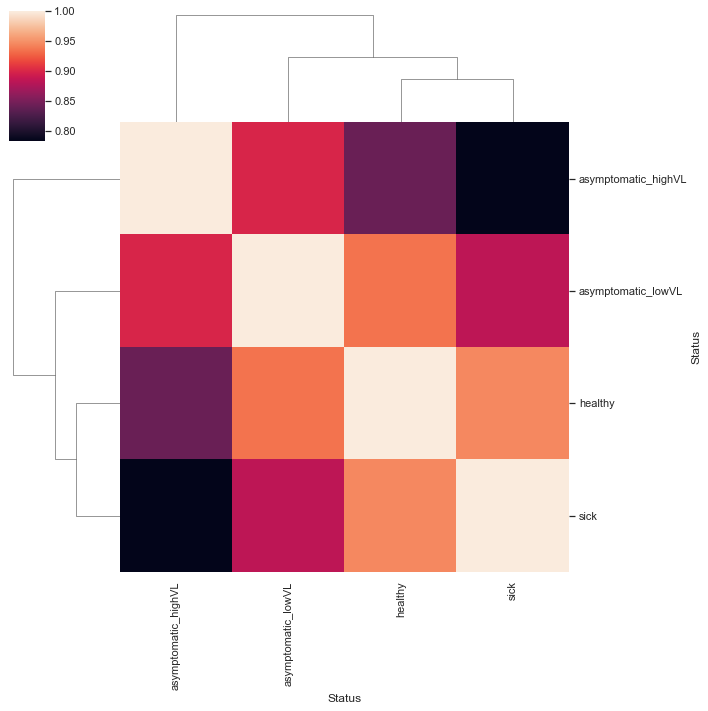

In [243]:
sns.clustermap(_data.T.corr())

In [244]:
_data.T.corr()

Status,asymptomatic_highVL,asymptomatic_lowVL,healthy,sick
Status,,,,
asymptomatic_highVL,1.000000,0.899414,0.842179,0.783498
asymptomatic_lowVL,0.899414,1.000000,0.935989,0.884817
healthy,0.842179,0.935989,1.000000,0.946611
sick,0.783498,0.884817,0.946611,1.000000


# get the error bars on these measurements by treating each individual

In [245]:
m = mdf[['SampleID', 'Status']]

In [246]:
data = mdf[mdf.C.str.contains('IGH')]

_data = data.groupby(['SampleID', 'C'])['#count'].sum().fillna(0)

#_data = _data.reset_index().melt(id_vars = 'SampleID')
# Fill na's (non-detected IGHEs)

#_data.fillna(0, inplace = True)

#data = _data

df = _data.unstack().fillna(0)

In [247]:
df = df[df.sum(axis = 1) > 8]

In [248]:
normed_df = df.div(df.sum(axis=1), axis=0)

normed_df

normed_df.reset_index(inplace = True)

normed_df = normed_df.melt(id_vars='SampleID')

data = pd.merge(normed_df, m, left_on='SampleID', right_on='SampleID')

data.drop_duplicates(inplace = True)

Text(1, 0.7, 'Patients Total56')

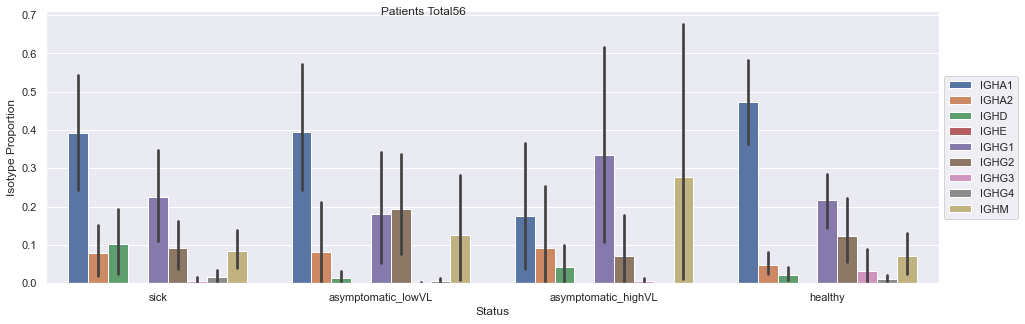

In [249]:
# Now With Error Bars
fig, ax = plt.subplots(figsize=(16, 5))
sns.barplot(data=data, x = 'Status', y = 'value', hue = 'C', ci = 95)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel("Isotype Proportion")
plt.text(1, 0.7, "Patients Total" + str(plot.SampleID.nunique()))

In [250]:
plot.drop_duplicates('SampleID').Status.value_counts()

healthy                21
asymptomatic_lowVL     17
sick                   12
asymptomatic_highVL     6
Name: Status, dtype: int64

## Drop IGHE and IGHG4 for a cleaner plot

In [251]:
plot = data[(data['C'] != 'IGHE') & (data['C'] != 'IGHG4')]

healthy                21
asymptomatic_lowVL     17
sick                   12
asymptomatic_highVL     6
Name: Status, dtype: int64


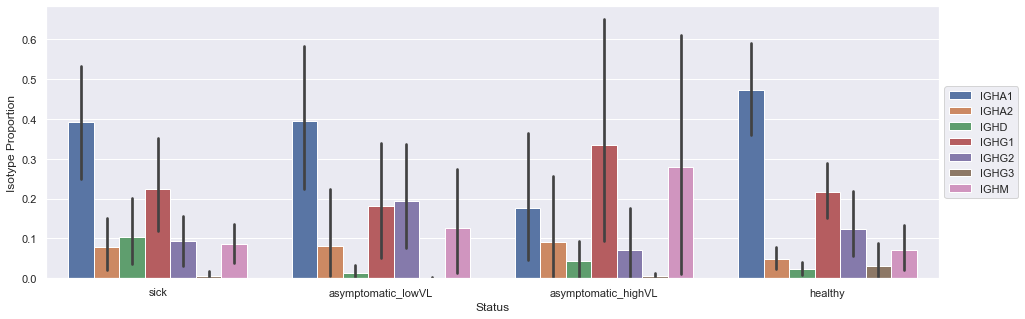

In [252]:
# Now With Error Bars
fig, ax = plt.subplots(figsize=(16, 5))
sns.barplot(data=plot, x = 'Status', y = 'value', hue = 'C', ci = 95)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel("Isotype Proportion")
print(plot.drop_duplicates('SampleID').Status.value_counts())

In [253]:
## Try grouping by covid+ covid-

In [254]:
mapping_dict = {'healthy': 'covid-'}

In [255]:
plot.Status.value_counts()

healthy                147
asymptomatic_lowVL     119
sick                    84
asymptomatic_highVL     42
Name: Status, dtype: int64

In [256]:
plot.Status.map(mapping_dict)

0         NaN
39        NaN
78        NaN
156       NaN
195       NaN
         ... 
206370    NaN
213264    NaN
216711    NaN
220158    NaN
227052    NaN
Name: Status, Length: 392, dtype: object

In [257]:
plot['Status2'] = plot['Status'].map(mapping_dict).fillna('covid+')

<ipython-input-257-abbc1f4dbd72>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot['Status2'] = plot['Status'].map(mapping_dict).fillna('covid+')


In [258]:
plot

,SampleID,C,value,Status,Status2
0,20H-119VI0131,IGHA1,0.692308,sick,covid+
39,20H-119VI0131,IGHA2,0.000000,sick,covid+
78,20H-119VI0131,IGHD,0.192308,sick,covid+
156,20H-119VI0131,IGHG1,0.000000,sick,covid+
195,20H-119VI0131,IGHG2,0.076923,sick,covid+
...,...,...,...,...,...
206370,20S-127VI0698,IGHD,0.027064,sick,covid+
213264,20S-127VI0698,IGHG1,0.307623,sick,covid+
216711,20S-127VI0698,IGHG2,0.156067,sick,covid+
220158,20S-127VI0698,IGHG3,0.004285,sick,covid+


covid+    35
covid-    21
Name: Status2, dtype: int64


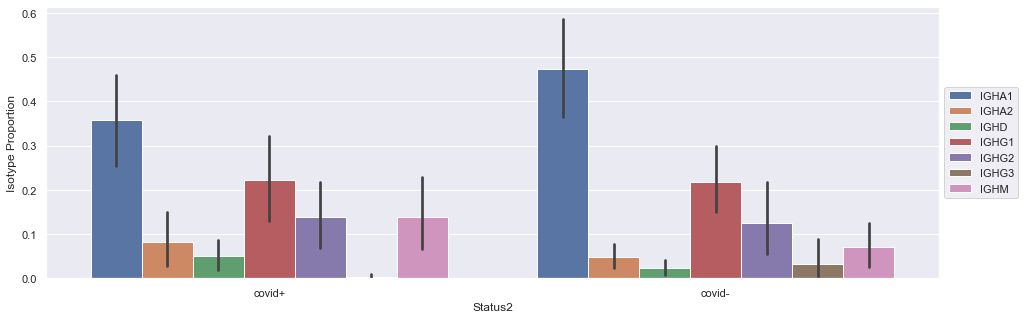

In [275]:
# Now With Error Bars
fig, ax = plt.subplots(figsize=(16, 5))
sns.barplot(data=plot, x = 'Status2', y = 'value', hue = 'C', ci = 95)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel("Isotype Proportion")
print(plot.drop_duplicates('SampleID').Status2.value_counts())

## Violin Plots cut at 0

covid+    35
covid-    21
Name: Status2, dtype: int64


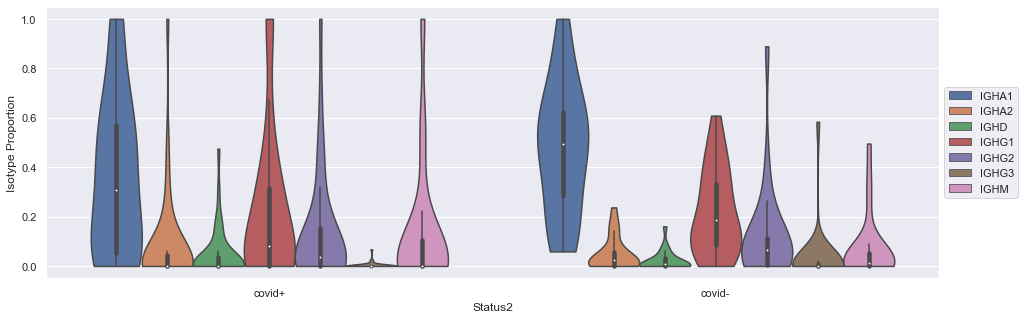

In [286]:
fig, ax = plt.subplots(figsize=(16, 5))
sns.violinplot(data=plot, x = 'Status2', y = 'value', hue = 'C', scale='width', cut = 0)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel("Isotype Proportion")
print(plot.drop_duplicates('SampleID').Status2.value_counts())

In [277]:
plot2 = pd.merge(plot, mdf, how='left', left_on='SampleID', right_on='SampleID')

pos    35
neg    21
Name: covid, dtype: int64


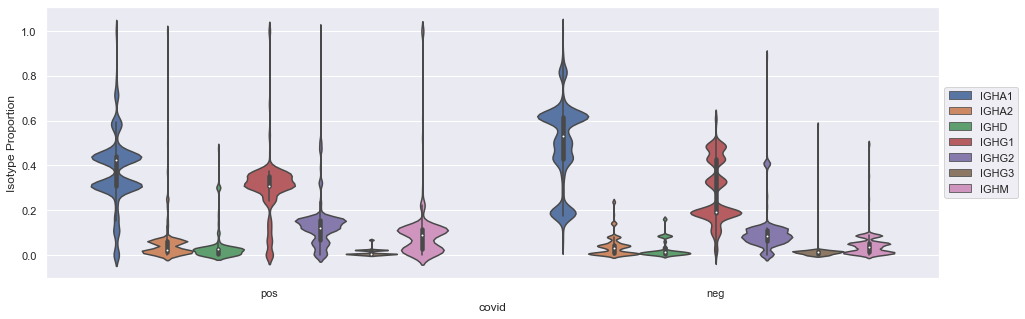

In [285]:
fig, ax = plt.subplots(figsize=(16, 5))
sns.violinplot(data=plot2, x = 'covid', y = 'value', hue = 'C_x', scale='width')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel("Isotype Proportion")
print(plot2.drop_duplicates('SampleID').covid.value_counts())

covid+    35
covid-    21
Name: Status2, dtype: int64


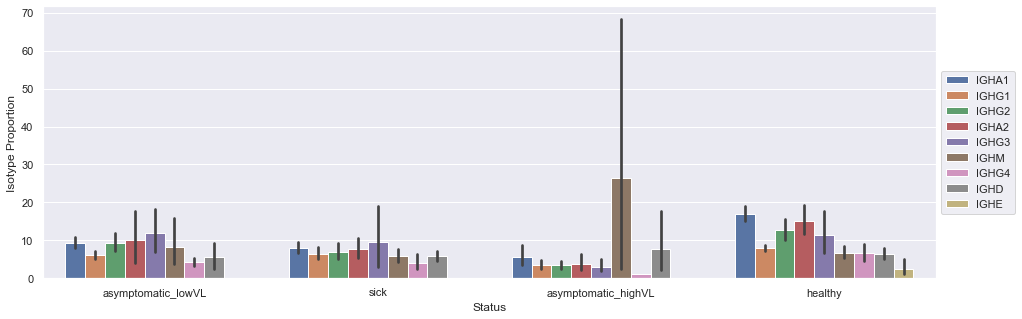

In [271]:
_data = mdf[mdf.C.str.contains('IGH')]
fig, ax = plt.subplots(figsize=(16, 5))
sns.barplot(data=_data, x = 'Status', y = '#count', hue = 'C', ci = 95)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel("Isotype Proportion")
print(plot.drop_duplicates('SampleID').Status2.value_counts())

In [273]:
_data[_data.C == 'IGHM'].sort_values('#count')

,#count,frequency,CDR3nt,CDR3aa,V,D,J,C,sample,Sample #,...,NC_002076.2 Torque teno virus 1,NC_003461.1 Human parainfluenza virus 1,NC_004718.3 SARS coronavirus,NC_006577.2 Human coronavirus HKU1,NC_009996.1 Human rhinovirus C,NC_038311.1 Human rhinovirus 1,NC_045512.2 Severe acute respiratory syndrome coronavirus 2 isolate Wuhan-Hu-1,truePosCovid,nonSARS,log_readcounts
27547,1,0.000119,GTGACTACAGCCCGTCGGTACTGGTTCGACCCCTGG,partial,*,*,IGHJ5*02,IGHM,20S-125VI0472,155,...,0.0,0.0,0.0,0.0,0.0,0.0,170.0,yes,0.0,0.000000
13903,1,0.000811,TGTGCAACAGCCCCGAAATTTATGATTACGTTT,partial,IGHV1-24*01,*,*,IGHM,20S-084VI0499,53,...,0.0,0.0,0.0,0.0,0.0,0.0,153.0,yes,0.0,0.000000
13287,1,0.006897,ATTTTTGGAGTGGTTAATCAATTTGACTACTGG,partial,IGHV4-31*01,*,IGHJ4*02,IGHM,20S-114VI0986,112,...,0.0,0.0,0.0,0.0,0.0,0.0,27.0,no,0.0,0.000000
12829,1,0.002075,TGCTGAATTCTGGCTGACCAGGGCAGTCACCAGAGCTCCAGACAAT...,partial,*,*,IGHJ4*02,IGHM,20S-125VI0948,166,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,no,0.0,0.000000
12826,1,0.002075,GGGGAGTTACGGAGGGCTATGGTTCGGGGAGTTATTACGAGTTTTT...,partial,*,*,IGHJ4*02,IGHM,20S-125VI0948,166,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,no,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20037,97,0.002193,TGTGCGAGAGCCAACCGCGAACTAGTACCAGCTGCTATAAGTCCTG...,CARANRELVPAAISPDWFDPW,IGHV3-48*04,IGHD2-2*02,IGHJ5*02,IGHM,20S-125VI0331,156,...,0.0,0.0,0.0,0.0,0.0,0.0,24.0,no,0.0,1.986772
11024,103,0.020004,TGTGCGAGATGGNNNNNNNCTGGGGTCCTGGCATTGTTGTCACAAT...,partial,IGHV3-53*04,*,IGHJ5*02,IGHM,20S-126V0813,180,...,0.0,0.0,0.0,0.0,0.0,0.0,10.0,no,0.0,2.012837
3175,105,0.323077,TGTGCGAGAACGTTTGTAGTGGTGGTAGCTGCTGGCTGGTTCGACC...,CARTFVVVVAAGWFDPW,IGHV3-21*01,IGHD2-15*01,IGHJ5*02,IGHM,20S-111VI0655,94,...,0.0,0.0,0.0,0.0,0.0,0.0,106.0,no,0.0,2.021189
20009,122,0.002764,TGTGCACACTCCCCGCTACTATATTGTGATGGGGACTGCTATTCCT...,CAHSPLLYCDGDCYSFDYW,IGHV2-5*02,IGHD2-21*02,IGHJ4*02,IGHM,20S-125VI0331,156,...,0.0,0.0,0.0,0.0,0.0,0.0,24.0,no,0.0,2.086360
